# Introduction

This notebook is a simple pytorch implementation for the paper titled "Point Transformer" found [here](https://arxiv.org/pdf/2012.09164) <br>
The authors used the transformer architecture for various tasks (classification, semantic and part segmentation).

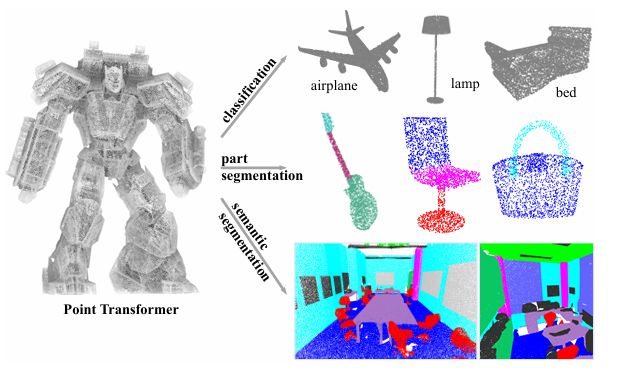

# Libraries

In [4]:
!pip install open3d

  Using cached open3d-0.18.0-cp310-cp310-manylinux_2_27_x86_64.whl.metadata (4.2 kB)
  Using cached dash-2.18.1-py3-none-any.whl.metadata (10 kB)
  Using cached ConfigArgParse-1.7-py3-none-any.whl.metadata (23 kB)
  Using cached ipywidgets-8.1.5-py3-none-any.whl.metadata (2.3 kB)
  Using cached addict-2.4.0-py3-none-any.whl.metadata (1.0 kB)
  Using cached pyquaternion-0.9.9-py3-none-any.whl.metadata (1.4 kB)
  Using cached dash_html_components-2.0.0-py3-none-any.whl.metadata (3.8 kB)
  Using cached dash_core_components-2.0.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached dash_table-5.0.0-py3-none-any.whl.metadata (2.4 kB)
  Using cached widgetsnbextension-4.0.13-py3-none-any.whl.metadata (1.6 kB)
  Using cached jupyterlab_widgets-3.0.13-py3-none-any.whl.metadata (4.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 4.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 63.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
!pip install fpsample

  Using cached fpsample-0.3.3-cp310-cp310-manylinux_2_28_x86_64.whl.metadata (8.6 kB)
Using cached fpsample-0.3.3-cp310-cp310-manylinux_2_28_x86_64.whl (331 kB)


In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import torch
from torch import nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

import open3d as o3d
import matplotlib.pyplot as plt

from scipy.spatial import distance

import fpsample

import time 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break
    break

import warnings
warnings.filterwarnings("ignore")
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Data Preparation

In [7]:

file = torch.load("/kaggle/input/small-s3dis/s3dis/Area_4/office_4.pth")
file


{'coord': array([[3.631, 4.859, 2.166],
        [3.631, 4.857, 2.183],
        [3.631, 4.855, 2.183],
        ...,
        [8.211, 5.374, 2.803],
        [8.194, 2.132, 2.811],
        [8.195, 2.132, 2.823]]),
 'color': array([[153., 162., 161.],
        [183., 189., 179.],
        [183., 189., 179.],
        ...,
        [ 98.,  92.,  78.],
        [ 96.,  90.,  54.],
        [ 96.,  90.,  58.]]),
 'semantic_gt': array([[11],
        [11],
        [11],
        ...,
        [ 2],
        [ 2],
        [ 2]]),
 'instance_gt': array([[ 0],
        [ 0],
        [ 0],
        ...,
        [37],
        [37],
        [37]]),
 'normal': array([[ 0.99993198, -0.01159089, -0.00129781],
        [ 0.99993198, -0.01159089, -0.00129781],
        [ 0.99993198, -0.01159089, -0.00129781],
        ...,
        [-0.00765495, -0.99959523, -0.02740049],
        [ 0.00583596,  0.99994978, -0.00814779],
        [ 0.00583596,  0.99994978, -0.00814779]])}

In [8]:
file["coord"][::10].shape

(82751, 3)

In [9]:
# pcd = o3d.geometry.PointCloud()
# pcd.points = o3d.utility.Vector3dVector(file["coord"][::6])
# pcd.colors = o3d.utility.Vector3dVector(file["color"][::6])
# o3d.visualization.draw_plotly([pcd])

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, N_POINTS):
        self.N_POINTS = N_POINTS
        self.root_dir = root_dir
        self.data_paths = []
        for file in os.listdir(root_dir):
            file_path = os.path.join(root_dir, file)
            self.data_paths.append(file_path)
    
    def __len__(self):
        return len(self.data_paths)
    
    def __getitem__(self, idx):
        file = torch.load(self.data_paths[idx])
        p = file["coord"]
        x = file["color"]
        y = file["semantic_gt"]
        
        samples_id = torch.randint(low = 0, high = p.shape[0], size = (N_POINTS, ))

        p = torch.tensor(p[samples_id, :]).to(torch.float32)
        x = torch.tensor(x[samples_id, :]).to(torch.float32)
        y = torch.tensor(y[samples_id]).squeeze().long()
        
        return p, x, y

# Architecture Breakdown

This notebook focuses on the semantic segmentation task only so I will try to implement the following architecture <br>
<br> <br>
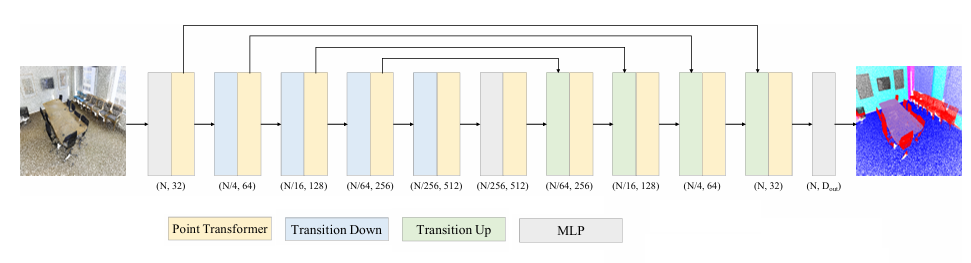

## Point Transformer Block

Lets have a look at the core of the network which is the point transformer layer

As mentioned in the paper it consists of the following <br> 
* 2 Linear Layers
* Point Transformer Layer 
* Skip connection
<br> <br>
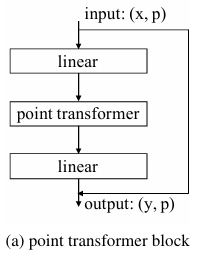

According to section 3.2 in the paper, the point transformer layer is as follows:

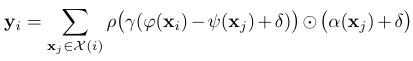

<br> <br>
where $\phi$, $\psi$, and $\alpha$ are linear layers. <br>

$\sigma$ and $\gamma$ are MLP (linear -> relu -> linear). <br>
$\rho$ is the softmax layer

**$X_i$** is the input feature vector (in our case RGB color of each point cloud) of shape (Batch Size, Num Points, 3) <br>
**$X_j$** is the K-nearest neighbors feature vector (in our case RGB color of each neighbor point cloud) of shape (Batch Size, Num Points, K, 3)


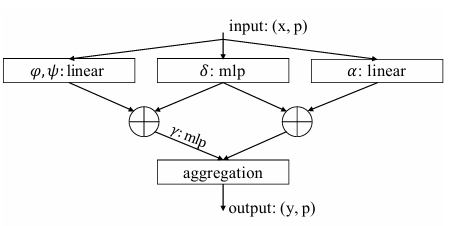

### Helper Functions <br>
Note: find_knn is so slow with large dims and needs optimization (running on CUDA for example) <br> <br>
**CPU running time** 
<br> 
for input of shape (2,12288, 3) 
* pair-wise distance and squareform:  2.83 seconds <br>
* tensor conversion and move to device: 0.55 seconds <br>
* argsort: 8.55 seconds <br>


In [10]:
def find_knn(p, k = 16):
    """
    p: points of shape (B, N, 3)
    k: number of nearest neighbors
    
    returns: 
            the indices of the k nearest neighbors for each point in p.
            Output shape = (B, N, k)
    """
    p = p.to(torch.float32)

    
    res = torch.zeros((*p.shape[:2], k)).to(p.device)
    
    for i in range(p.shape[0]):
        
        points = p[i, :, :]
        
        #t0 = time.time()
        D = distance.squareform(distance.pdist(points.detach().cpu()))
        #print("pair-wise distance and squareform", time.time() - t0)
        
        #t0 = time.time()
        
        D = torch.tensor(D).to(p.device)
        #print("tensor conversion and move to device", time.time() - t0)
        
        #t0 = time.time()
        knn_i = torch.argsort(D, dim = 1)[:, 1 : 1 + k]
        #print("argsort", time.time() - t0)
        #knn_i = np.argsort(D, axis=1)[:, 1 : 1 + k]
        
        res[i, :, :] = knn_i.to(p.device)
    
    return res #torch.tensor(res)   

def index_points(points, idx):
    
    p = points.unsqueeze(2).expand(-1, -1, idx.shape[2], -1)
    
    
    ids = idx.unsqueeze(3).expand(-1, -1, -1, points.shape[-1]).to(torch.int64)
    
    
    nearest_points = torch.gather(p, dim=1, index=ids)
    
    return nearest_points
    

    
def farthest_point_sample(points, output_points_dim):
    if len(points.shape) < 3:
        points = points[None, ...]
        
    res = torch.zeros(points.shape[0], output_points_dim, 3)
    res_idx = torch.zeros(points.shape[0], output_points_dim)
    
    for i in range(points.shape[0]):
        
        fp_samples_idx = fpsample.fps_sampling(points[i,:, :], output_points_dim)
        
        res[i, :, :] = points[i, fp_samples_idx, :]
        res_idx[i, :] = torch.tensor(fp_samples_idx)
        
    return res, res_idx




In [11]:
f, fi = farthest_point_sample(torch.rand((8, 2048, 3)), 512)
f.shape, fi.shape

(torch.Size([8, 512, 3]), torch.Size([8, 512]))

In [12]:
p = torch.tensor([[[0,0,0], [0,0,1],[0,0,2],[0,0,5]]])

print("Points")

print(p)

i = find_knn(p, k = 2)

print("Nearest Neighbors")

index_points(p, i)


Points
tensor([[[0, 0, 0],
         [0, 0, 1],
         [0, 0, 2],
         [0, 0, 5]]])
Nearest Neighbors


tensor([[[[0, 0, 1],
          [0, 0, 2]],

         [[0, 0, 0],
          [0, 0, 2]],

         [[0, 0, 1],
          [0, 0, 0]],

         [[0, 0, 2],
          [0, 0, 1]]]])

In [14]:
knn_test_tensor = torch.rand(2, 4096*3, 3)
knn_test_tensor = knn_test_tensor.cuda() if torch.cuda.is_available() else knn_test_tensor
find_knn(torch.rand(2, 4096*3, 3), k = 4).shape

torch.Size([2, 12288, 4])

In [15]:
class PointTransformerLayer(nn.Module):
    def __init__(self, n_points, input_dim, output_dim):
        super().__init__()
        self.phi = nn.Linear(output_dim, output_dim)
        
        self.psi = nn.Linear(input_dim, output_dim)
        
        self.gamma = nn.Sequential(nn.Linear(output_dim, output_dim),  
                                   nn.ReLU(),
                                   nn.Linear(output_dim, output_dim))
        
        self.sigma = nn.Sequential(nn.Linear(3, 3),  
                                   nn.ReLU(),
                                   nn.Linear(3, output_dim))
        
        self.alpha = nn.Linear(input_dim, output_dim)
        
        self.softmax = nn.Softmax(dim = -1)
    
    def forward(self, p, x):
        """
        x: features (B, n_points, 3)
        p: coords (B, n_points, 3)
        
        """
        x = x[:, :, None, :]
        
        knn_idx = find_knn(p, k = 16)
        
        knn_points = index_points(p, knn_idx)
        
        
        xi = self.phi(x)
        
        xj = self.psi(knn_points)
        
        
        pos_emb = self.sigma(p[:, :, None, :] - knn_points)
        
        
        out1 = self.gamma(xi - xj + pos_emb)
        
        out1 = self.softmax(out1)
        
        
        weights = self.alpha(knn_points) + pos_emb
        
        out = torch.sum(out1 * weights, axis = 2)
        #print("out from PT", out.shape)
        
        return out
        

In [16]:
ptl = PointTransformerLayer(1024, 3, 32)
i1 = torch.rand((8, 1024, 3))
n1 = torch.rand((8, 1024, 32))
o1 = ptl(i1, n1)
o1.shape

torch.Size([8, 1024, 32])

In [17]:
class BatchNorm1d_P(nn.BatchNorm1d):
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        #  input: (b, n, c)
        return super().forward(x.transpose(1, 2)).transpose(1, 2)


class BatchNorm2d_P(nn.BatchNorm2d):
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # input: (b, n, k, c)
        x = x.permute(0, 3, 1, 2)   # (b, c, n, k)
        x = super().forward(x)
        return x.permute(0, 2, 3, 1)    # (b, n, k, c)


class PointTransformerBlock(nn.Module):
    def __init__(self, n_points, input_dim, output_dim, share_planes=8, nsample=16):
        super(PointTransformerBlock, self).__init__()
        
        self.linear1 = nn.Linear(output_dim, output_dim, bias=False)
        self.bn1 = BatchNorm1d_P(output_dim)

        self.transformer = PointTransformerLayer(n_points, input_dim, output_dim)
        self.bn2 = BatchNorm1d_P(output_dim)

        self.linear3 = nn.Linear(output_dim, output_dim, bias=False)
        self.bn3 = BatchNorm1d_P(output_dim)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, px):
        """
        Input:
            px: [xyz, features]
        Output:
            [xyz, new_features]
        """
        xyz, features = px  # (b,n,3), (b,n,c)
        identity = features
        features = self.relu(self.linear1(features))
        
        features = self.relu(self.transformer(xyz, features))
        features = self.linear3(features)
        
        
        features += identity
        features = self.relu(features)
        return [xyz, features]  # (b,n,3), (b,n,c)


In [18]:
ptb = PointTransformerBlock(1024, 3, 32)
i1 = torch.rand((8, 1024, 3))
n1 = torch.rand((8, 1024, 32))
p1, x1 = ptb([i1, n1])
p1.shape, x1.shape

(torch.Size([8, 1024, 3]), torch.Size([8, 1024, 32]))

# Transition Down Block

In [19]:
class TransitionDown(nn.Module):
    """
        N: number of points of the output
        K: number of nearest neighbors to aggregate over
        input_dim: the last dimension of the features tensor
    """
    def __init__(self, N, K, input_dim):
        
        super().__init__()
        self.N = N
        self.K = K
        self.knn_mlp = nn.Sequential(nn.Linear(input_dim, input_dim*2), 
                                 nn.ReLU(), 
                                 nn.MaxPool2d((K, 1)))

        
    def forward(self, px):
        """
        px: list of [points: shape (B, N, 3),
                     features: shape (B, N, input_dim)]
        
        returns 
                farthest_points_sampled of shape (B, N/4, 3) 
                and  
                max_pooled_features_over_K (B, N/4, input_dim * 2)
        """
        p, x = px
        
        new_p, new_p_idx = farthest_point_sample(p.detach(), self.N)
        
        
        knn_idx = find_knn(new_p, 16)
        
        knn_x = index_points(x, knn_idx)
        
        aggregated_over_k = self.knn_mlp(knn_x)
        
        
        return new_p, aggregated_over_k.squeeze()
        

In [20]:
td = TransitionDown(N = 512, K = 16, input_dim = 32)
p2, x2 = td([p1, x1])
p2.shape, x2.shape

(torch.Size([8, 512, 3]), torch.Size([8, 512, 64]))

# Transition Up Block

In [21]:
class TransitionUp(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, input_dim//2)
        self.linear2 = nn.Linear(input_dim, input_dim//2)
        self.relu = nn.ReLU()
        
    def forward(self, px1_px2):
        p1, x1, p2, x2 = px1_px2
        
        #print(x1.shape)
        x1 = self.linear1(x1)
        
        #print(x1.shape, x2.shape)
        
        x1 = nn.functional.interpolate(x1.permute(0, 2, 1), 
                                       size=x2.shape[1], 
                                       mode='linear').permute(0, 2, 1)
        
        return p2, x1 + x2
        #print(x1.shape)
        #return x1
        

In [22]:
tu = TransitionUp(64)
p3, x3 = tu([p2, x2, torch.rand((8, 1024, 32)), torch.rand((8,1024, 32))])
p3.shape, x3.shape

(torch.Size([8, 1024, 32]), torch.Size([8, 1024, 32]))

# Point Transformer Network

In [23]:
class PointTransformer(nn.Module):
    def __init__(self, input_dim, n_points, num_classes):
        super().__init__()
        self.input_dim = input_dim
        self.n_points = n_points
        self.num_classes = num_classes
        
        self.mlp0 = nn.Sequential(nn.Linear(input_dim, input_dim),
                                  nn.ReLU(),
                                  nn.Linear(input_dim, 32))
        
        self.pt0 = PointTransformerBlock(n_points, 3, 32)
        
        self.td1 = TransitionDown(n_points//4, 16, 32)
        self.pt1 = PointTransformerBlock(n_points//4, 3, 64)
        
        self.td2 = TransitionDown(n_points//16, 16, 64)
        self.pt2 = PointTransformerBlock(n_points//16, 3, 128)
        
        self.td3 = TransitionDown(n_points//64, 16, 128)
        self.pt3 = PointTransformerBlock(n_points//64, 3, 256)
        
        self.td4 = TransitionDown(n_points//256, 16, 256)
        self.pt4 = PointTransformerBlock(n_points//256, 3, 512)
        
        self.mlp2 = nn.Sequential(nn.Linear(512, 512),
                                  nn.ReLU(),
                                  nn.Linear(512, 512))
        
        self.pt5 = PointTransformerBlock(n_points//256, 3, 512)
        
        self.tu6 = TransitionUp(512)
        self.pt6 = PointTransformerBlock(n_points//256, 3, 256)
        
        self.tu7 = TransitionUp(256)
        self.pt7 = PointTransformerBlock(n_points//64, 3, 128)
        
        
        self.tu8 = TransitionUp(128)
        self.pt8 = PointTransformerBlock(n_points//16, 3, 64)
        
        
        self.tu9 = TransitionUp(64)
        self.pt9 = PointTransformerBlock(n_points//4, 3, 32)
        
        self.mlp3 = nn.Sequential(nn.Linear(32, 32),
                                  nn.ReLU(),
                                  nn.Linear(32, num_classes))
        
        self.log_softmax = nn.LogSoftmax(dim = -1)
                                
        
        
    def forward(self, px):
        p, x = px
        x0 = self.mlp0(x)
        p0, x0 = self.pt0([p, x0])
        
        p1, x1 = self.td1([p0, x0])
        p1, x1 = self.pt1([p1, x1])
        
        p2, x2 = self.td2([p1, x1])
        p2, x2 = self.pt2([p2, x2])
        
        p3, x3 = self.td3([p2, x2])
        p3, x3 = self.pt3([p3, x3])
        
        
        p4, x4 = self.td4([p3, x3])
        p4, x4 = self.pt4([p4, x4])
        
        x5 = self.mlp2(x4)
        p6, x6 = self.pt5([p4, x5])
        
        p7, x7 = self.tu6([p6, x6, p3, x3])
        p7, x7 = self.pt6([p7, x7])
        
        p8, x8 = self.tu7([p7, x7, p2, x2])
        p8, x8 = self.pt7([p8, x8])
        
        p9, x9 = self.tu8([p8, x8, p1, x1])
        p9, x9 = self.pt8([p9, x9])
        
        p10, x10 = self.tu9([p9, x9, p0, x0])
        p10, x10 = self.pt9([p10, x10])
        
        out = self.log_softmax(self.mlp3(x10))
        
        return out
        
        
        
        
        

In [24]:
IS_CUDA_AVAILABLE = torch.cuda.is_available()

In [25]:
x_0 = torch.rand((2, 4096*2, 3))
p_0 = torch.rand((2, 4096*2, 3))
model = PointTransformer(3, 4096*2, 10)

props = model([p_0, x_0])

In [26]:
props.shape

torch.Size([2, 8192, 10])

In [39]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.95)

In [28]:
loss_fn = torch.nn.NLLLoss() #torch.nn.CrossEntropyLoss()

In [29]:
os.listdir('/kaggle/input/small-s3dis/s3dis/Area_1')[:4]

['office_4.pth', 'office_11.pth', 'office_9.pth', 'office_27.pth']

In [31]:
file = torch.load("/kaggle/input/small-s3dis/s3dis/Area_4/office_4.pth")
file

{'coord': array([[3.631, 4.859, 2.166],
        [3.631, 4.857, 2.183],
        [3.631, 4.855, 2.183],
        ...,
        [8.211, 5.374, 2.803],
        [8.194, 2.132, 2.811],
        [8.195, 2.132, 2.823]]),
 'color': array([[153., 162., 161.],
        [183., 189., 179.],
        [183., 189., 179.],
        ...,
        [ 98.,  92.,  78.],
        [ 96.,  90.,  54.],
        [ 96.,  90.,  58.]]),
 'semantic_gt': array([[11],
        [11],
        [11],
        ...,
        [ 2],
        [ 2],
        [ 2]]),
 'instance_gt': array([[ 0],
        [ 0],
        [ 0],
        ...,
        [37],
        [37],
        [37]]),
 'normal': array([[ 0.99993198, -0.01159089, -0.00129781],
        [ 0.99993198, -0.01159089, -0.00129781],
        [ 0.99993198, -0.01159089, -0.00129781],
        ...,
        [-0.00765495, -0.99959523, -0.02740049],
        [ 0.00583596,  0.99994978, -0.00814779],
        [ 0.00583596,  0.99994978, -0.00814779]])}

**Sampling data so all points have the same shape**

In [32]:
p, x = file["coord"], file["color"]
y = file["semantic_gt"]

torch.manual_seed(0)

N_POINTS = 1024 * 10

idx = torch.randint(low = 0, high = p.shape[0], size = (N_POINTS, ))

p = torch.tensor(p[None, idx, :]).to(torch.float32)
x = torch.tensor(x[None, idx, :]).to(torch.float32)
y = torch.tensor(y[None, idx]).to(torch.int8)

In [33]:
p.shape, x.shape, y.shape

(torch.Size([1, 10240, 3]),
 torch.Size([1, 10240, 3]),
 torch.Size([1, 10240, 1]))

In [49]:
# pcd = o3d.geometry.PointCloud()

# pcd.points = o3d.utility.Vector3dVector(np.asarray(p.squeeze()))
# pcd.colors = o3d.utility.Vector3dVector(np.asarray(x.squeeze()))
# o3d.visualization.draw_plotly([pcd])

In [35]:
train_ds = CustomDataset("/kaggle/input/small-s3dis/s3dis/Area_4", N_POINTS)
train_loader = DataLoader(train_ds, batch_size = 2, shuffle = False, num_workers = 4)

In [36]:
model = PointTransformer(3, N_POINTS, 50)

In [37]:
if IS_CUDA_AVAILABLE:
    model = model.cuda()

Lets **overfit** to the data to check the model learning capabilities

In [40]:
loss_history = []

for i in range(100):
    for p, x, y in train_loader:
        optimizer.zero_grad()
        if IS_CUDA_AVAILABLE:
            p, x, y = p.cuda(), x.cuda(), y.cuda()
        
        x = (x - x.mean())/(x.std()+0.01)
        p = (p - p.mean())/(p.std()+0.01)
        y_pred = model([p, x])
        
        loss = loss_fn(y_pred.permute(0, 2, 1), y)

        loss.backward()
        optimizer.step()
        
        
        break
    
    loss_history.append(loss.item())
    if i % 5 == 0:
        print(f"epoch: {i}, loss: {loss.item()}")

    

epoch: 0, loss: 3.9964370727539062
epoch: 5, loss: 3.3693695068359375
epoch: 10, loss: 2.811861038208008
epoch: 15, loss: 2.670609712600708
epoch: 20, loss: 2.01314640045166
epoch: 25, loss: 2.1895155906677246
epoch: 30, loss: 1.9866796731948853
epoch: 35, loss: 1.953796625137329
epoch: 40, loss: 2.0960192680358887
epoch: 45, loss: 1.9105026721954346
epoch: 50, loss: 1.8156254291534424
epoch: 55, loss: 1.7772533893585205
epoch: 60, loss: 1.7129303216934204
epoch: 65, loss: 1.6992664337158203
epoch: 70, loss: 1.7183339595794678
epoch: 75, loss: 1.690896987915039
epoch: 80, loss: 1.7021563053131104
epoch: 85, loss: 1.665485143661499
epoch: 90, loss: 1.6523363590240479
epoch: 95, loss: 1.648141860961914


Text(0, 0.5, 'Loss')

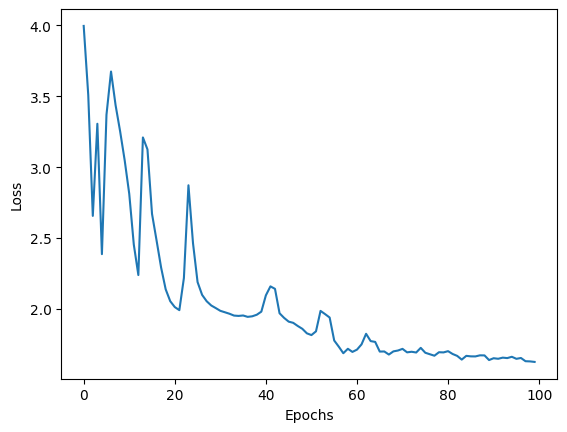

In [44]:
plt.plot(np.arange(len(loss_history)), loss_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")

Loss curve looks **OK**

lets generate random colors to segment different shapes

In [45]:
import random
get_colors = lambda n: ["#%06x" % random.randint(0, 0xFFFFFF) for _ in range(n)]
COLORS = get_colors(50)
COLORS = np.array([tuple(int(h.lstrip("#")[i:i+2], 16) for i in (0, 2, 4)) for h in COLORS])
COLORS.shape

(50, 3)

In [95]:
pcd = o3d.geometry.PointCloud()

for p, x, y in train_loader:

    if IS_CUDA_AVAILABLE:
        p, x, y = p.cuda(), x.cuda(), y.cuda()
    
    x = (x - x.mean())/(x.std()+0.01)
    p = (p - p.mean())/(p.std()+0.01)
    y_pred = model([p, x])

    y_cls = torch.argmax(y_pred, dim = -1)
    
    

    pcd.points = o3d.utility.Vector3dVector(np.asarray(p[0, :].squeeze()))
    pcd.colors = o3d.utility.Vector3dVector(COLORS[y_cls[0, :]])
    break
    
o3d.visualization.draw_plotly([pcd])
   

In [96]:
pcd_true = o3d.geometry.PointCloud()

pcd_true.points = o3d.utility.Vector3dVector(np.asarray(p[0, :].squeeze()))
pcd_true.colors = o3d.utility.Vector3dVector(COLORS[y[0, :]])
    
o3d.visualization.draw_plotly([pcd_true])

In [94]:
file2 = torch.load("/kaggle/input/small-s3dis/s3dis/Area_4/office_4.pth")

p22, x22 = file2["coord"], file2["color"]
y22 = file2["semantic_gt"]

#torch.manual_seed(0)

N_POINTS = 1024 * 20

idx22 = torch.randint(low = 0, high = p22.shape[0], size = (N_POINTS, ))

p22 = torch.round(torch.tensor(p22[None, idx22, :]).to(torch.float16), decimals = 2)
x22 = torch.round(torch.tensor(x22[None, idx22, :]).to(torch.float16), decimals = 2)
y22 = torch.tensor(y22[None, idx22]).to(torch.int8)

# p22 = nn.functional.interpolate(p22.permute(0, 2, 1), scale_factor=2, mode='area').permute(0, 2, 1)
# x22 = nn.functional.interpolate(x22.permute(0, 2, 1), scale_factor=2, mode='area').permute(0, 2, 1)

pcd22 = o3d.geometry.PointCloud()

pcd22.points = o3d.utility.Vector3dVector(np.asarray(p22.squeeze()))
pcd22.colors = o3d.utility.Vector3dVector(np.asarray(x22.squeeze()))


o3d.visualization.draw_plotly([pcd22])

Next Steps:
* Optimize KNN (using CUDA)
* Train the model on the whole dataset
* Find better ways to visualize segmentation masks (as these samples look sparse and needs filling or interpolation)